In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from datasets.cifar10_dataset import Cifar10Dataset

In [2]:
trainset = Cifar10Dataset(is_train=True)
testset = Cifar10Dataset(is_train=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import einops

In [4]:
trainiter = iter(trainloader)

def show_batch(batch):
    images, labels = batch['image'], batch['label']
    images = einops.rearrange(trainset.inv_transform(images), 'b c h w -> b h w c')

    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, len(images)//4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f'{labels[i].item()}: {trainset.classes[labels[i].item()]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

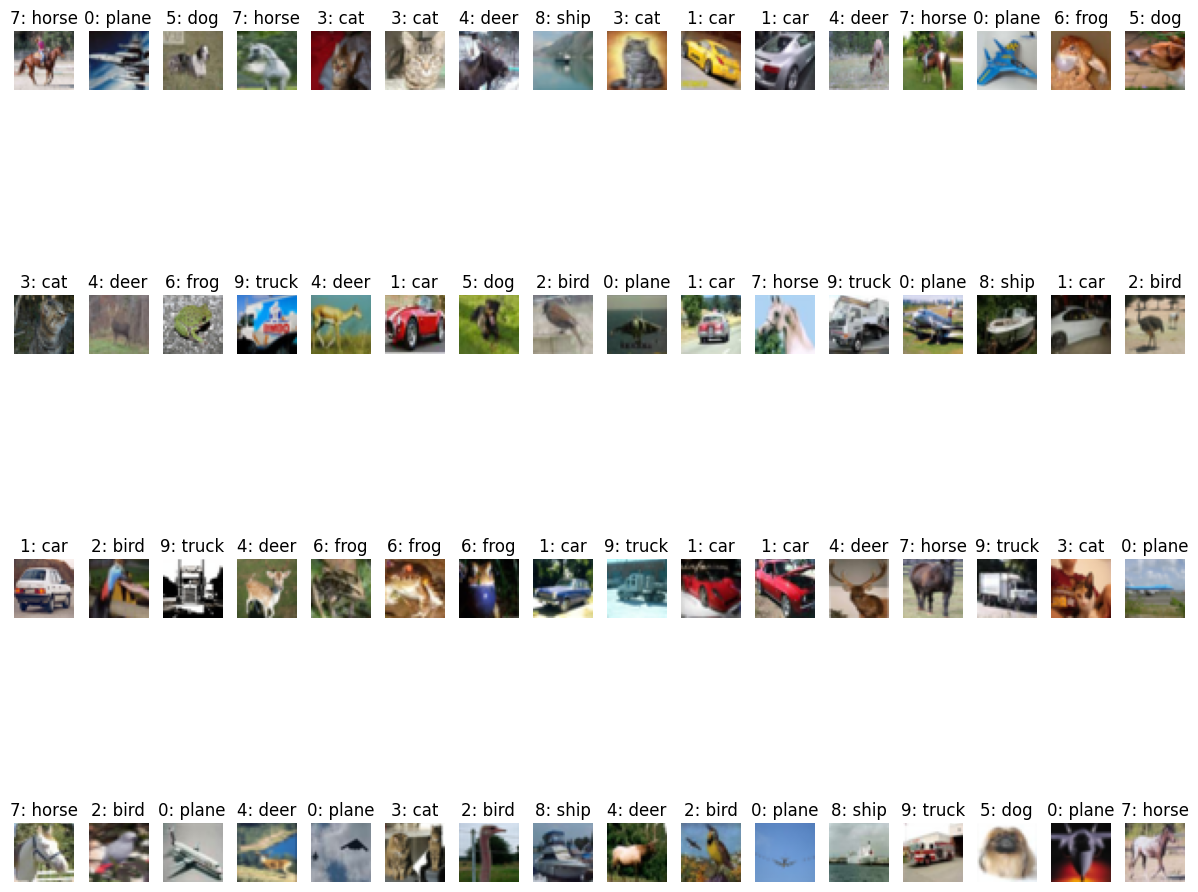

In [5]:
show_batch(next(trainiter))

In [6]:
import models

In [7]:
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# net = models.CNN(input_nc = 3, num_classes = 10, net_name=None, use_dropout=False, pool_type='max').to(device)
net = models.ResNet(input_nc=3, num_classes=10, net_name='resnet50', use_dropout=False, pool_type='max').to(device)
net

ResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [10]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # Evaluate on test set at the end of each epoch
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in testloader:
            test_images, test_labels = test_data['image'].to(device), test_data['label'].to(device)
            test_outputs = net(test_images)
            test_loss += criterion(test_outputs, test_labels).item()
            _, predicted = torch.max(test_outputs, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
    
    test_accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    print(f'Epoch {epoch + 1} validation - Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.2f}%')
    net.train()

print('Finished Training')

Epoch 1, Batch 500, Loss: 11.130
Epoch 1 validation - Loss: 1.953, Accuracy: 33.53%
Epoch 2, Batch 500, Loss: 8.882
Epoch 2 validation - Loss: 1.521, Accuracy: 48.46%
Epoch 3, Batch 500, Loss: 7.055
Epoch 3 validation - Loss: 1.243, Accuracy: 57.03%
Epoch 4, Batch 500, Loss: 5.932
Epoch 4 validation - Loss: 1.098, Accuracy: 61.52%
Epoch 5, Batch 500, Loss: 5.192
Epoch 5 validation - Loss: 0.985, Accuracy: 65.42%
Epoch 6, Batch 500, Loss: 4.730
Epoch 6 validation - Loss: 0.912, Accuracy: 68.25%
Epoch 7, Batch 500, Loss: 4.371
Epoch 7 validation - Loss: 0.857, Accuracy: 70.15%
Epoch 8, Batch 500, Loss: 4.062
Epoch 8 validation - Loss: 0.800, Accuracy: 72.13%
Epoch 9, Batch 500, Loss: 3.780
Epoch 9 validation - Loss: 0.749, Accuracy: 74.06%
Epoch 10, Batch 500, Loss: 3.588
Epoch 10 validation - Loss: 0.716, Accuracy: 75.57%
Epoch 11, Batch 500, Loss: 3.419
Epoch 11 validation - Loss: 0.693, Accuracy: 76.02%
Epoch 12, Batch 500, Loss: 3.247
Epoch 12 validation - Loss: 0.697, Accuracy: 76.6

In [11]:
PATH = './cifar10_resnet50.pth'
torch.save(net.state_dict(), PATH)
